In [1]:
from preprocessing.tissue_detection import threshold_based
import openslide
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import numpy as np
import random
import pandas as pd
from preprocessing.tile_generation.utils import prep_utils as slide_utils
%matplotlib inline

In [2]:
data_dir = "/home/jiayun/Documents/deepstorage/PANDA_challenge/"
slides_dir = f"{data_dir}/train_images/"
masks_dir = f"{data_dir}/train_label_masks/"
train_slides_df = pd.read_csv(f"{data_dir}/train.csv", index_col='image_id')

### Test tissue detection

In [3]:
def plot_slides(samples, slides_dir, n_row=2):
    assert len(samples) % n_row == 0, "Please change n_row or n_samples"
    tot = 2 * len(samples)
    n_col = tot // n_row
    f, ax = plt.subplots(n_row, n_col, figsize=(18,9))
    counter = 0
    for info in samples.itertuples(index=True):
        slide_id = info.Index
        provider = info.data_provider
        group = info.isup_grade
        dw_sample = slide_utils.read_downsample_slide(slides_dir, f"{slide_id}.tiff")
        slide = openslide.OpenSlide(f"{slides_dir}/{slide_id}.tiff")
        mask = threshold_based.get_tissue_area(slide)
        
        ax[counter//n_col, counter%n_col].imshow(dw_sample)
        ax[counter//n_col, counter%n_col].set_title(f"name: {slide_id}\nprovider: {provider}\ngroup: {group}")
        counter += 1
        
        ax[counter//n_col, counter%n_col].imshow(dw_sample)
        ax[counter//n_col, counter%n_col].imshow(mask, alpha=0.6)
        ax[counter//n_col, counter%n_col].axis('off')
        counter += 1
    plt.show() 


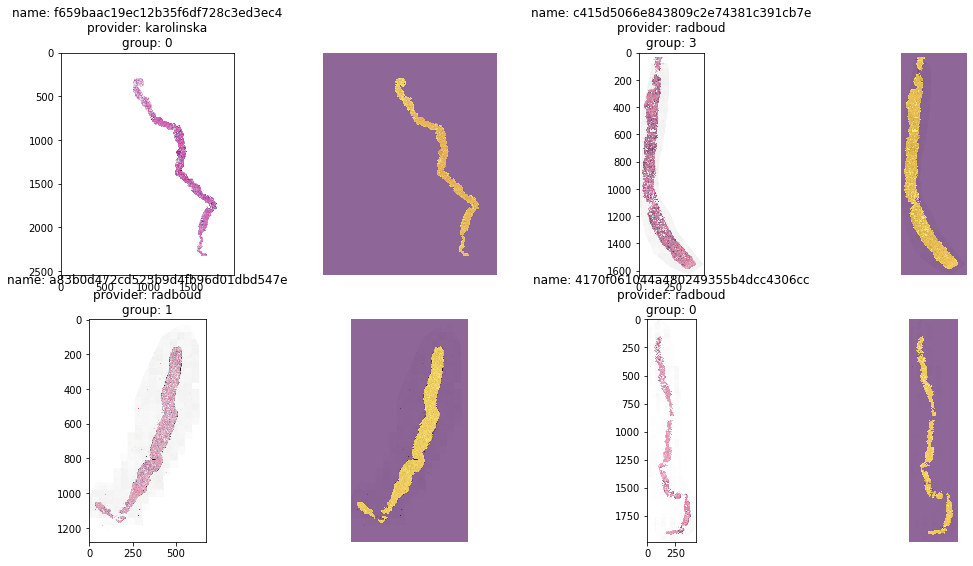

In [4]:
samples = train_slides_df.sample(4)
samples
plot_slides(samples, slides_dir, n_row=2)

### Test tile generation

In [47]:
def display_mask(mask_data, provider):
    mask_data = Image.fromarray(mask_data.astype(np.uint8))
    preview_palette = np.zeros(shape=768, dtype=int)
    if provider == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 
                                           0.5, 0.5, 0.5, 
                                           0, 1, 0, 
                                           1, 1, 0.7, # yellow
                                           1, 0.5, 0, # orange
                                           1, 0, 0]) * 255).astype(int)
    elif provider == 'karolinska':
        # provider: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 
                                          0, 1, 0, 
                                          1, 0, 0]) * 255).astype(int)
    mask_data.putpalette(data=preview_palette.tolist())
    mask_data = mask_data.convert(mode='RGB')
    
    return mask_data

In [48]:
def plot_tiles(orig_tiles, norm_tiles, tissue_masks, label_masks, slide_id, provider, n_row=3):
    assert len(orig_tiles) % n_row == 0, "Please change n_row or n_samples"
    tot = 3 * len(orig_tiles)
    n_col = tot // n_row
    f, ax = plt.subplots(n_row, n_col, figsize=(27,9))
    counter = 0
    for orig_tile, norm_tile, mask, label in zip(orig_tiles, norm_tiles, tissue_masks, label_masks):
        converted_mask = display_mask(label, provider)
        ax[counter//n_col, counter%n_col].imshow(norm_tile)
        ax[counter//n_col, counter%n_col].axis('off')
        ax[counter//n_col, counter%n_col].set_title(f"Norm name: {slide_id}\nprovider: {provider}")
        counter += 1
        
        ax[counter//n_col, counter%n_col].imshow(orig_tile)
        ax[counter//n_col, counter%n_col].axis('off')
        ax[counter//n_col, counter%n_col].set_title("Orig")
        counter += 1
        
        ax[counter//n_col, counter%n_col].imshow(orig_tile)
        ax[counter//n_col, counter%n_col].imshow(converted_mask, alpha=0.6)
        ax[counter//n_col, counter%n_col].axis('off')
        counter += 1
        
    plt.show() 

In [6]:
from preprocessing.tile_generation import generate_grid
from preprocessing.normalization import reinhard_bg
tile_normalizer = reinhard_bg.ReinhardNormalizer()

In [28]:
sample = train_slides_df.sample(1)
sample

,data_provider,isup_grade,gleason_score
image_id,,,
0125392d1963a6b69a37f9e30333d68a,karolinska,2,3+4


In [29]:
tile_generator = generate_grid.TileGeneratorGrid(slides_dir, f"{sample.index[0]}.tiff", masks_dir, verbose=True)
orig_tiles, norm_tiles, locations, tissue_masks, label_masks \
            = tile_generator.extract_all_tiles(512, 0.25, 0.5, 1, tile_normalizer)

Generate 152 tiles in the grid
Time to generate 152 tiles from 0125392d1963a6b69a37f9e30333d68a slide: 17.84


/home/jiayun/anaconda3/envs/py36_pytorch12/lib/python3.6/site-packages/skimage/morphology/misc.py:212: UserWarning: the min_size argument is deprecated and will be removed in 0.16. Use area_threshold instead.
  "0.16. Use area_threshold instead.")


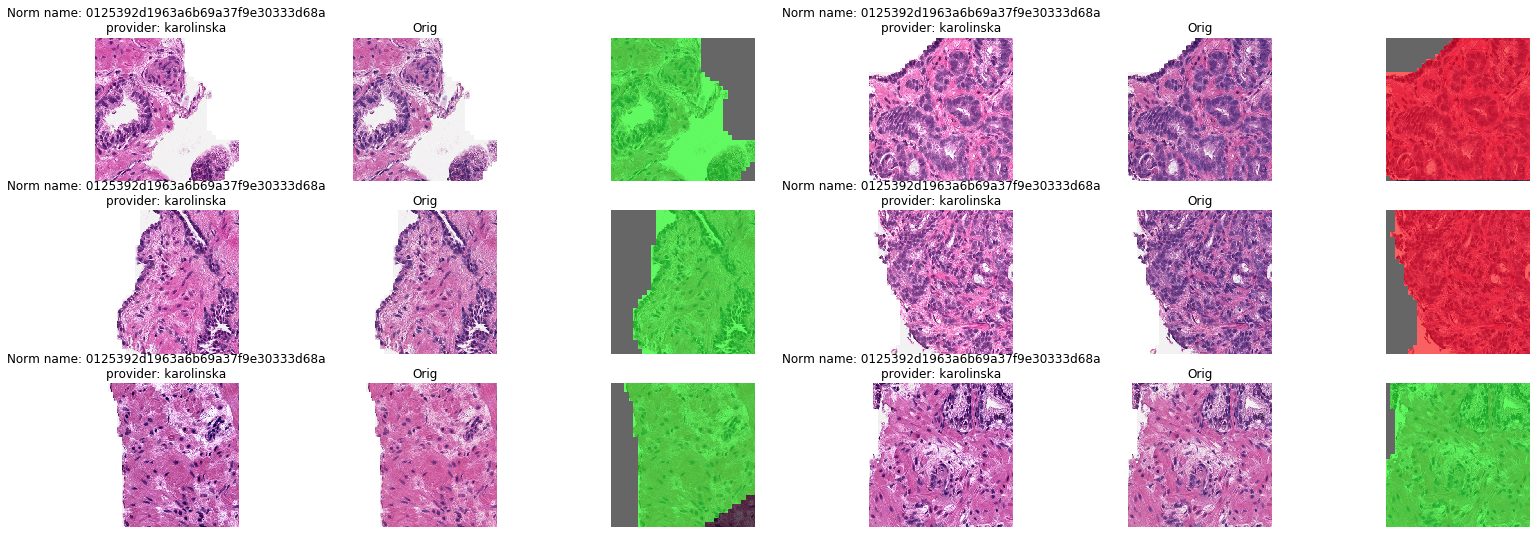

In [50]:
sample_tile_idx = random.sample(range(0, len(orig_tiles)), 6)
sample_orig, sample_norm = orig_tiles[sample_tile_idx], norm_tiles[sample_tile_idx]
sample_mask, sample_label = tissue_masks[sample_tile_idx], label_masks[sample_tile_idx]
plot_tiles(sample_orig, sample_norm, sample_mask, sample_label, sample.index[0], sample.data_provider[0])